In [5]:
import numpy as np
import pandas as pd
from scipy.signal.windows import gaussian
from scipy.ndimage import convolve1d
from sklearn.preprocessing import MinMaxScaler
import torch

def normalise(columns):
    for column in columns:
        column_to_scale = cleaned[column].values.reshape(-1, 1)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_column = scaler.fit_transform(column_to_scale)
        cleaned[column] = scaled_column.flatten()

def normalise_negative(columns):
    for column in columns:
        max_abs = np.max(np.abs(cleaned[column]))
        cleaned[column] = cleaned[column] / max_abs
        print(column, max_abs)
        
def log_smoothen(columns):
    for column in columns:
        b = gaussian(14, 8)
        cleaned[column] = convolve1d(cleaned[column], b/b.sum())
        cleaned[column] = cleaned[column].pct_change()#np.log(cleaned[column] / cleaned[column].shift(1))
    
def std_return(columns):
    for column in columns:
        cleaned[column] = (cleaned[column]-cleaned[column].shift(1)) / cleaned[column].shift(1)
        
def de_inflate(columns):
    for column in columns:
        cleaned[column] = cleaned[column]/cleaned['CPI']
        
def remove_outliers(columns):
    for column in columns:
        Q1 = cleaned[column].quantile(0.10)
        Q3 = cleaned[column].quantile(0.90)
        IQR = Q3 - Q1

        # Define bounds for identifying outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = cleaned[(cleaned[column] < lower_bound) | (cleaned[column] > upper_bound)]
        print(column, "outliers", outliers)

        # Remove outliers
        df_clean = cleaned[(cleaned[column] >= lower_bound) & (cleaned[column] <= upper_bound)]

        

In [6]:
cleaned = pd.read_excel('decorrelated.xlsx')
features = ['SPDR','SPX','DXY','CPI','Fed Rate','Volume']

de_inflate(['SPDR', 'SPX'])
# remove_outliers(['SPDR'])
log_smoothen(['SPDR'])
normalise(['t'])
normalise_negative(['Fed Rate', 'SPX','DXY','SPDR', 'CPI_pct'])

cleaned = cleaned.iloc[1:]
print(cleaned)

for feature in features:
    mean = np.mean(cleaned[feature])
    m1 = np.min(cleaned[feature])
    m2 = np.max(cleaned[feature])
    print(feature, f"{mean:.2f}", f"\t{m1:.3f}", f"\t{m2:.3f}")

SPDR outliers Empty DataFrame
Columns: [Unnamed: 0, Date, Fed Rate, Volume, CPI, SPDR, SPDR_Close, DXY, SPX, t, CPI_pct]
Index: []
Fed Rate 5.41
SPX 0.8179127317522776
DXY 4804.509765625
SPDR 0.006111932150491328
CPI_pct 3.12121146907125
      Unnamed: 0       Date  Fed Rate      Volume      CPI      SPDR  \
1              1 2004-11-22  0.371534  1392700000  190.300 -0.091167   
2              2 2004-11-23  0.369686  1428300000  190.300 -0.041534   
3              3 2004-11-24  0.373383  1149600000  190.300 -0.295081   
4              4 2004-11-26  0.371534   504580000  190.300 -0.287974   
5              5 2004-11-29  0.375231  1378500000  190.300 -0.318135   
...          ...        ...       ...         ...      ...       ...   
4813        4813 2024-01-05  0.985213  3844370000  312.332 -0.132900   
4814        4814 2024-01-08  0.985213  3742320000  312.332 -0.095676   
4815        4815 2024-01-09  0.985213  3529960000  312.332 -0.031571   
4816        4816 2024-01-10  0.985213  349

In [7]:
torch.save(cleaned, open('cleaned.pt', 'wb'))

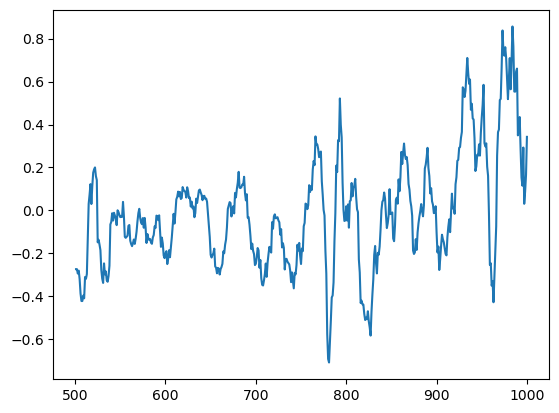

In [8]:
import matplotlib.pyplot as plt
plt.plot(cleaned['SPDR'][500:1000], label='SPDR')